In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#FUNCTION: create_placeholders
# Example call:   X, Y = create_placeholders(100, 6)
def create_nn_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
   
    Arguments:
    n_x -- scalar, size of the input X 
    n_y -- scalar, number of classes in Y 
   
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
   
    Note:
    - None is used as the second dimension below because it enables flexibility on the number of examples
      we may have in the placeholders.
      Note that the number of examples during test/train is different.
    """

    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    Y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
   
    return X, Y

In [3]:
# FUNCTION: 
# Example call:   tf_variable = get_nn_parameter(...)
def get_nn_parameter(variable_scope, variable_name, dim1, dim2):
    '''
    Used to retrieve or create new NN parameters (weights & biases)
    When calling, the corresponding NNparameter's dimensions need to be specified too.
    Returns a tensorflow variable. Note that NN parameters need to be tensorflow variables
    so that values can be changed whenever needed when training. Also note that it is 
    explicitly defined that the created variable is TRAINABLE.
    '''
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      v = tf.get_variable(variable_name, 
                          [dim1, dim2], 
                          trainable=True, 
                          initializer = tf.contrib.layers.xavier_initializer())
    return v

In [4]:
# FUNCTION: 
# Example call:   nn_parameters = initialize_layer_parameters([3, 5, 5, 2])
def initialize_layer_parameters(num_units_in_layers):
    '''
    NOTE THAT THE LAST LAYER HAS TO HAVE AT LEAST 2 UNITS BCZ SOFTMAX IS USED IN THIS NN MODEL
    Returns a dictionary of created weights and biases for all layers of the NN.
    Note that # units can vary in each layer.
    Exmaple return: parameters = {"W1": tf_variable_for_W1, "b1": tf_variable_for_b1, ...}
    '''
    
    parameters = {}
    L = len(num_units_in_layers)
     
    for i in range (1, L):
        #print("W" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(num_units_in_layers[i-1]))
        temp_weight = get_nn_parameter("weights",
                                       "W"+str(i), 
                                       num_units_in_layers[i], 
                                       num_units_in_layers[i-1])
        parameters.update({"W" + str(i) : temp_weight})  
        
        #print("b" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(1))
        temp_bias = get_nn_parameter("biases",
                                     "b"+str(i), 
                                     num_units_in_layers[i], 
                                     1)
        parameters.update({"b" + str(i) : temp_bias})  
        
    return parameters

In [5]:
# FUNCTION: 
# Example call: ZL = forward_propagation_with_relu(X_train, [3, 5, 5, 2], nn_parameters)
def forward_propagation_with_relu(X, num_units_in_layers, parameters):
    '''
    Returns ZL, which is the linear output of the output layer (layer L)
    AL is also calculated but it is not returned or used. The optimizer function takes ZL as input, not the AL.
    What activation function is used in output layer plays role when calculating the cost 
    so that you need to call the right cost (or cross entropy) function in compute_cost(...) function
    '''
    L = len(num_units_in_layers)
    
    A_temp = X
    for i in range (1, L):
        #W = get_nn_parameter("weights", "W"+str(i), num_units_in_layers[i], num_units_in_layers[i-1])
        W = parameters.get("W"+str(i))
        #b = get_nn_parameter("biases", "b"+str(i), num_units_in_layers[i], 1)
        b = parameters.get("b"+str(i))
        Z_temp = tf.add(tf.matmul(W, A_temp), b)
        A_temp = tf.nn.relu(Z_temp)       # Example: A1 = relu(Z1)1, Note that A in the last (output) 
                                          # layer is irrelevant bcz we return ZL

    return Z_temp   #This is the linear output of last layer

In [6]:
# FUNCTION
# This function requires update if softmax is not used in the output layer
def compute_cost(ZL, Y, parameters, mb_size, lambd):
    """
    This function should be used for multinomial mutually exclusive classification, i.e. pick one out of N classes. 
    Also applicable when N = 2.
    The labels must be one-hot encoded or can contain soft class probabilities: a particular example can belong to
    class A with 50% probability and class B with 50% probability. Note that strictly speaking it doesn't mean that
    it belongs to both classes, but one can interpret the probabilities this way.
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as ZL
    mb_size -- number of samples in the given mini-batch
    lambd -- lambda regularization parameter (regularization deactivated is lambd=0.)
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    
    # This cost calculation is unregularized. cost = (1/m) sum(Loss(y_hat(i), y(i))), where i = 1,..,mb_size 
    #tf.reduce_mean(..) function finds the mean of costs of examples in the given mini-batch
    cost_unregularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    # Add L2 regularization: cost += (lambd / (2 * mb_size)) * sum(W(i,j)**2), where i:1,..,n[l] and j:1,..,n[l-1] 
    # L:number of layers. Since the dict parameters includes both W and b, it needs to be divided with 2 to find L
    L = len(parameters) // 2
    
    # The list will have L elements, each holding the sum of weight matrix values in each layer. Later, these
    # weight values need to be summed up again
    list_sum_weights = []
    
    for i in range (0, L):
        list_sum_weights.append(tf.nn.l2_loss(parameters.get("W"+str(i+1))))
    
    # in the following calculation, since the l2_loss returns "sum(t ** 2) / 2", where the sum of squares is already
    # divided by 2, there is no need to bultiply the mb_size with 2
    #regularization_effect = (lambd / mb_size) * sum(list_sum_weights)
    regularization_effect = tf.multiply((lambd / mb_size), tf.add_n(list_sum_weights))
    cost = tf.add(cost_unregularized, regularization_effect)
    
    return cost

In [7]:
# TEST CODE FOR TESTING THE compute_cost(...) function
tf.reset_default_graph()
tf.set_random_seed(1)  # tf.reset_default_graph() needs to be run first before calling tf.set_random_seed(..)

num_units_in_layers = [5,4,3,2]

X = tf.placeholder(shape=[5, 3], dtype=tf.float32)
Y = tf.placeholder(shape=[2, 3], dtype=tf.float32)
parameters = initialize_layer_parameters(num_units_in_layers)
ZL = forward_propagation_with_relu(X, num_units_in_layers, parameters)
cost = compute_cost(ZL, Y, parameters, 3, 0.05)
optimizer =  tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)
init = tf.global_variables_initializer() 

test_sess = tf.Session()
test_sess.run(init)
_ , minibatch_cost = test_sess.run([optimizer, cost], 
                                   feed_dict={X: [[-1.,4.,-7.],[2.,6.,2.],[3.,3.,9.],[8.,4.,4.],[5.,3.,5.]], 
                                              Y: [[0.6, 0., 0.3], [0.4, 0., 0.7]]})

#initial_cost = test_sess.run(cost, feed_dict={X: [[-1.,4.,-7.],[2.,6.,2.],[3.,3.,9.],[8.,4.,4.],[5.,3.,5.]],
#                                              Y: [[0.6, 0., 0.3], [0.4, 0., 0.7]]})


print(minibatch_cost)

test_sess.close()

1.1387842


In [8]:
def nn_model(X_train, Y_train, X_test, Y_test, learning_rate, num_epochs,
             minibatch_size, num_units_in_layers, lambd, print_cost):
    """
    Returns NN parameters after the completion of training.
    """
    
    tf.reset_default_graph()     # to be able to rerun the model without overwriting tf variables
    #tf.set_random_seed(1)       # tf.reset_default_graph() needs to be run first before calling tf.set_random_seed(..)

    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    X, Y = create_nn_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_layer_parameters(num_units_in_layers)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ZL = forward_propagation_with_relu(X, num_units_in_layers, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    mb_size = tf.placeholder(tf.float32, name='mb_size')  #minibatch_size to use in regularization
    cost = compute_cost(ZL, Y, parameters, mb_size, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer() 
    
    sess = tf.Session()
    sess.run(init)
    
    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.                       # Defines a cost related to an epoch
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        #seed = seed + 1
        minibatches = num_minibatches
            
        for minibatch in range (minibatches):
            #print(learning_rate)
            # Select a minibatch
            minibatch_X = X_train
            minibatch_Y = Y_train
                
            # IMPORTANT: The line that runs the graph on a minibatch.
            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            numExamplesInCurrentBatch = minibatch_X.shape[1]
            _ , minibatch_cost = sess.run([optimizer, cost], 
                                          feed_dict={X: minibatch_X, 
                                                     Y: minibatch_Y,
                                                     mb_size: numExamplesInCurrentBatch})
                
            #print("numExamplesInCurrentBatch = " + str(numExamplesInCurrentBatch))
               
            # IN CASE, YOU IMPLEMENT  DROPOUT REGULARIZATION, HERE IS THE EXAMPLE CODE. PLACE IT WHERE IT NEEDS TO BE
            # IT JUST NEEDS TO BE USED THE COMPUTE_COST FUNCTION ACTUALLY...
            # A1 = tf.nn.dropout(A1, keep_prob=keep_p)
                
            epoch_cost += minibatch_cost / num_minibatches
            
        # Print the cost every epoch
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)
                
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # lets save the parameters in a variable
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")

    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Train Accuracy:", accuracy.eval(session=sess, feed_dict={X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval(session=sess, feed_dict={X: X_test, Y: Y_test}))
    
    sess.close()
    
    return parameters

Cost after epoch 0: 1.211954
Cost after epoch 10: 0.998918
Cost after epoch 20: 0.817819
Cost after epoch 30: 0.660246
Cost after epoch 40: 0.136063
Cost after epoch 50: 0.032631


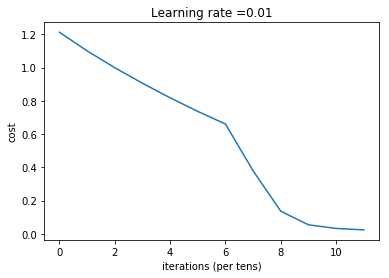

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


{'W1': array([[-0.11512583,  0.19306064, -0.81568444, -0.051974  , -0.09166741],
        [-0.820789  , -0.20797144,  0.09524529,  0.00412735,  0.73404497],
        [-0.35475236, -1.0209918 ,  0.5200488 , -0.17201208,  0.33751267],
        [-0.4849321 , -0.6735957 , -0.5696551 , -0.575947  , -0.8014692 ]],
       dtype=float32),
 'W2': array([[ 0.07387549, -0.8189524 , -0.78105015, -0.4279087 ],
        [-0.31153423,  0.5844176 , -0.03496258,  0.06460911],
        [ 0.32245827,  0.82985896, -0.02295909, -0.4270891 ]],
       dtype=float32),
 'W3': array([[ 0.05739209,  0.5837955 ,  0.8621709 ],
        [-0.6989815 , -0.2702042 , -0.18813634]], dtype=float32),
 'b1': array([[ 0.9870131 ],
        [-0.62879145],
        [ 0.2566456 ],
        [ 0.28253913]], dtype=float32),
 'b2': array([[0.623573 ],
        [1.083892 ],
        [1.3184326]], dtype=float32),
 'b3': array([[1.0303432],
        [0.9391197]], dtype=float32)}

In [9]:
# X/Y_train and X/Y_test need to be replaced with file paths
X_train = np.array([[-1.,4.,-7.],[2.,6.,2.],[3.,3.,9.],[8.,4.,4.],[5.,3.,5.]])
Y_train = np.array([[1., 1., 1.], [0., 0., 0.]])
X_test = np.array([[2.],[3.],[1.],[4.],[7.]])
Y_test = np.array([[1.],[0.]])
learning_rate = 0.01 
num_epochs = 60
minibatch_size = 3 
num_units_in_layers = [5,4,3,2] 
lambd = 0. 
print_cost = True

nn_model(X_train, Y_train, X_test, Y_test, learning_rate, num_epochs,
         minibatch_size, num_units_in_layers, lambd, print_cost)
                  
#parameters = nn_model(X_train = np.array([[-1.,4.,-7.],[2.,6.,2.],[3.,3.,9.],[8.,4.,4.],[5.,3.,5.]]),
#                      Y_train = np.array([[1., 1., 1.], [0., 0., 0.]]), 
#                      X_test = np.array([[2.],[3.],[1.],[4.],[7.]]),
#                      Y_test = np.array([[1.],[0.]]))

In [10]:
#TODO
# Add tf.Dataset functionality and read data from csv files
# Split data into train, dev, test sets by using tf.Split(...) function
# Add mini-batch support with shuffling implemented   (use tf.train.shuffle_batch(...))
# Save NN parameters somewhere after (How?)

abc = []
abc.append(1)
abc.append(5)
print(abc)
print(sum(abc))

[1, 5]
6


In [11]:
der = np.array([2,2,2])
print(der.shape)

(3,)
